In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

PyTorch: 2.6.0+cu124
CUDA: True


In [2]:
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")

TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

print(f"Train exists: {os.path.exists(TRAIN_VIDEOS)}")
print(f"Test exists: {os.path.exists(TEST_VIDEOS)}")

Train exists: True
Test exists: True


In [3]:
CONFIG = {
    # Data
    'image_size': (128, 128),
    
    # Model - SMALLER bottleneck forces abstraction
    'latent_dim': 128,  # Reduced from 512! Forces compression
    
    # Training - FEWER epochs to prevent overfitting
    'batch_size': 64,
    'num_epochs': 25,  # Reduced from 50
    'learning_rate': 2e-4,  # Lower LR for stability
    'weight_decay': 1e-4,
    
    # Early stopping
    'patience': 5,
    'min_delta': 1e-4,
    
    # Scoring
    'temporal_sigma': 3,  # Gaussian smoothing for temporal scores
    
    'seed': 42,
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

print(f"Device: {DEVICE}")
print(f"Key changes:")
print(f"  - Latent dim: 128 (was 512)")
print(f"  - Epochs: 25 (was 50)")
print(f"  - No skip connections")
print(f"  - MSE loss only")

Device: cuda
Key changes:
  - Latent dim: 128 (was 512)
  - Epochs: 25 (was 50)
  - No skip connections
  - MSE loss only


In [4]:
def discover_frames(video_dir):
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        return frames
    
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except:
                continue
        frames[vid].sort(key=lambda x: x[0])
    
    return dict(frames)

train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)

total_train = sum(len(v) for v in train_frames.values())
total_test = sum(len(v) for v in test_frames.values())

print(f"Train: {len(train_frames)} videos, {total_train} frames")
print(f"Test: {len(test_frames)} videos, {total_test} frames")

Train: 16 videos, 9204 frames
Test: 21 videos, 11706 frames


In [5]:
test_frame_ids = []
test_frame_info = []

for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))

print(f"Test frame IDs: {len(test_frame_ids)}")

Test frame IDs: 11706


In [6]:
def load_frames_to_gpu(frames_dict, image_size, device, desc="Loading"):
    total = sum(len(v) for v in frames_dict.values())
    H, W = image_size
    all_frames = torch.zeros(total, 3, H, W, dtype=torch.float32, device=device)
    frame_info = []
    
    idx = 0
    pbar = tqdm(total=total, desc=desc)
    
    for vid in sorted(frames_dict.keys()):
        for fnum, path in frames_dict[vid]:
            img = Image.open(path).convert('RGB')
            img = img.resize((W, H), Image.BILINEAR)
            arr = np.array(img, dtype=np.float32) / 127.5 - 1.0
            tensor = torch.from_numpy(arr).permute(2, 0, 1)
            all_frames[idx] = tensor
            frame_info.append((vid, fnum))
            idx += 1
            pbar.update(1)
    
    pbar.close()
    return all_frames, frame_info

print("Loading training data...")
train_tensors, train_info = load_frames_to_gpu(train_frames, CONFIG['image_size'], DEVICE, "Train")
print(f"Train: {train_tensors.shape}")

print("\nLoading testing data...")
test_tensors, test_info = load_frames_to_gpu(test_frames, CONFIG['image_size'], DEVICE, "Test")
print(f"Test: {test_tensors.shape}")
print(f"GPU memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading training data...


Train:   0%|          | 0/9204 [00:00<?, ?it/s]

Train: torch.Size([9204, 3, 128, 128])

Loading testing data...


Test:   0%|          | 0/11706 [00:00<?, ?it/s]

Test: torch.Size([11706, 3, 128, 128])
GPU memory: 4.11 GB


In [7]:
class GPUDataset(Dataset):
    def __init__(self, tensors, frame_info=None):
        self.tensors = tensors
        self.frame_info = frame_info
    
    def __len__(self):
        return len(self.tensors)
    
    def __getitem__(self, idx):
        if self.frame_info:
            return self.tensors[idx], self.frame_info[idx][0], self.frame_info[idx][1]
        return self.tensors[idx]

train_dataset = GPUDataset(train_tensors)
test_dataset = GPUDataset(test_tensors, test_info)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 144
Test batches: 183


In [8]:
class SimpleAutoencoder(nn.Module):
    """
    Simple autoencoder with TIGHT bottleneck.
    NO skip connections - forces all information through bottleneck.
    This is KEY for anomaly detection - anomalies can't be reconstructed well
    because they weren't seen during training.
    """
    def __init__(self, latent_dim=128):
        super().__init__()
        
        # Encoder - aggressive downsampling
        self.encoder = nn.Sequential(
            # 128 -> 64
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 64 -> 32
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 32 -> 16
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16 -> 8
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8 -> 4
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Bottleneck - TIGHT compression
        self.fc_enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, latent_dim),
        )
        
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 32 -> 64
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 64 -> 128
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
    
    def encode(self, x):
        x = self.encoder(x)
        z = self.fc_enc(x)
        return z
    
    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

model = SimpleAutoencoder(latent_dim=CONFIG['latent_dim']).to(DEVICE)
n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,}")
print(f"Latent dim: {CONFIG['latent_dim']} (TIGHT bottleneck)")

# Test
with torch.no_grad():
    x = torch.randn(2, 3, 128, 128, device=DEVICE)
    y = model(x)
print(f"Forward: {x.shape} -> {y.shape}")

Parameters: 7,683,523
Latent dim: 128 (TIGHT bottleneck)
Forward: torch.Size([2, 3, 128, 128]) -> torch.Size([2, 3, 128, 128])


In [9]:
criterion = nn.MSELoss()  # Simple MSE - no fancy losses

optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Simple step scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print("Loss: MSE only (simple is better)")
print(f"Optimizer: Adam (lr={CONFIG['learning_rate']})")

Loss: MSE only (simple is better)
Optimizer: Adam (lr=0.0002)


In [10]:
print("=" * 60)
print("TRAINING (with early stopping)")
print("=" * 60)

history = {'loss': [], 'time': []}
best_loss = float('inf')
patience_counter = 0

for epoch in range(CONFIG['num_epochs']):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}", leave=False)
    for batch in pbar:
        if isinstance(batch, (list, tuple)):
            frames = batch[0]
        else:
            frames = batch
        
        optimizer.zero_grad(set_to_none=True)
        recon = model(frames)
        loss = criterion(recon, frames)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    scheduler.step()
    
    avg_loss = epoch_loss / len(train_loader)
    epoch_time = time.time() - start_time
    history['loss'].append(avg_loss)
    history['time'].append(epoch_time)
    
    # Early stopping check
    if avg_loss < best_loss - CONFIG['min_delta']:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.5f} | Best: {best_loss:.5f} | "
          f"Patience: {patience_counter}/{CONFIG['patience']} | Time: {epoch_time:.1f}s")
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("\n" + "=" * 60)
print(f"Training complete! Best loss: {best_loss:.5f}")
print("=" * 60)

TRAINING (with early stopping)


Epoch 1/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  1 | Loss: 0.08312 | Best: 0.08312 | Patience: 0/5 | Time: 8.7s


Epoch 2/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  2 | Loss: 0.01474 | Best: 0.01474 | Patience: 0/5 | Time: 7.9s


Epoch 3/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  3 | Loss: 0.00940 | Best: 0.00940 | Patience: 0/5 | Time: 8.0s


Epoch 4/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  4 | Loss: 0.00733 | Best: 0.00733 | Patience: 0/5 | Time: 8.1s


Epoch 5/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  5 | Loss: 0.00606 | Best: 0.00606 | Patience: 0/5 | Time: 8.2s


Epoch 6/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  6 | Loss: 0.00537 | Best: 0.00537 | Patience: 0/5 | Time: 8.3s


Epoch 7/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  7 | Loss: 0.00483 | Best: 0.00483 | Patience: 0/5 | Time: 8.4s


Epoch 8/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  8 | Loss: 0.00438 | Best: 0.00438 | Patience: 0/5 | Time: 8.3s


Epoch 9/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  9 | Loss: 0.00411 | Best: 0.00411 | Patience: 0/5 | Time: 8.2s


Epoch 10/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.00572 | Best: 0.00411 | Patience: 1/5 | Time: 8.2s


Epoch 11/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.00919 | Best: 0.00411 | Patience: 2/5 | Time: 8.1s


Epoch 12/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.00646 | Best: 0.00411 | Patience: 3/5 | Time: 8.1s


Epoch 13/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.00519 | Best: 0.00411 | Patience: 4/5 | Time: 8.1s


Epoch 14/25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.00450 | Best: 0.00411 | Patience: 5/5 | Time: 8.1s

Early stopping at epoch 14

Training complete! Best loss: 0.00411


In [11]:
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth')))
model.eval()
print("Loaded best model")

Loaded best model


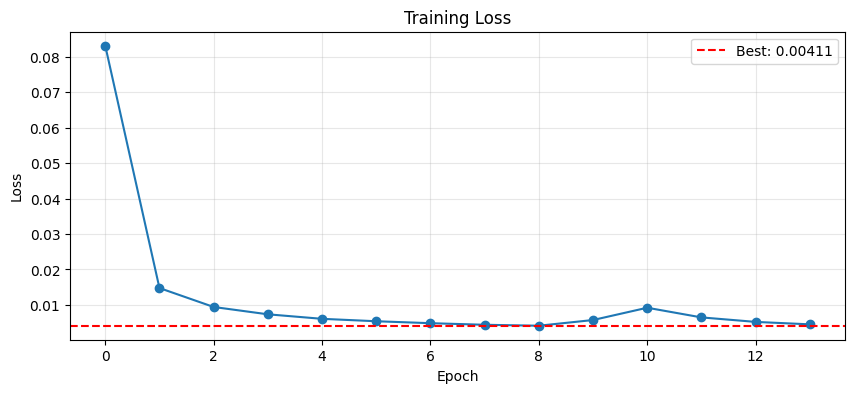

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(history['loss'], marker='o')
plt.axhline(y=best_loss, color='r', linestyle='--', label=f'Best: {best_loss:.5f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'training.png'))
plt.show()

In [13]:
@torch.no_grad()
def compute_reconstruction_scores(model, tensors, frame_info, batch_size=128):
    """
    Compute reconstruction error.
    Use MEAN of per-pixel MSE, but also track MAX error for later.
    """
    model.eval()
    scores_mean = {}
    scores_max = {}
    
    for start in tqdm(range(0, len(tensors), batch_size), desc="Reconstruction"):
        end = min(start + batch_size, len(tensors))
        batch = tensors[start:end]
        recon = model(batch)
        
        # Per-pixel squared error
        pixel_error = (batch - recon) ** 2
        
        # Mean error per frame
        mean_err = torch.mean(pixel_error, dim=(1, 2, 3))
        
        # Max error per frame (catches localized anomalies)
        max_err = torch.amax(pixel_error, dim=(1, 2, 3))
        
        for i in range(len(batch)):
            vid, fnum = frame_info[start + i]
            fid = f"{vid}_{fnum}"
            scores_mean[fid] = float(mean_err[i].cpu())
            scores_max[fid] = float(max_err[i].cpu())
    
    return scores_mean, scores_max

recon_mean, recon_max = compute_reconstruction_scores(model, test_tensors, test_info)
print(f"Reconstruction scores computed: {len(recon_mean)}")

Reconstruction:   0%|          | 0/92 [00:00<?, ?it/s]

Reconstruction scores computed: 11706


In [14]:
def compute_temporal_scores_improved(recon_scores, test_frames, sigma=3):
    """
    Improved temporal scoring:
    1. Smooth the reconstruction errors with Gaussian filter
    2. Compute difference from smoothed baseline
    3. Anomalies are frames that deviate from local trend
    """
    scores = {}
    
    for vid in sorted(test_frames.keys()):
        fnums = sorted([f[0] for f in test_frames[vid]])
        errs = np.array([recon_scores.get(f"{vid}_{fn}", 0) for fn in fnums])
        
        if len(errs) < 5:
            for i, fn in enumerate(fnums):
                scores[f"{vid}_{fn}"] = 0.0
            continue
        
        # Smooth the errors (local baseline)
        smoothed = gaussian_filter1d(errs, sigma=sigma)
        
        # Deviation from smoothed baseline
        deviation = np.abs(errs - smoothed)
        
        # Normalize by local std
        local_std = gaussian_filter1d(np.abs(errs - smoothed), sigma=sigma*2) + 1e-8
        normalized_deviation = deviation / local_std
        
        for i, fn in enumerate(fnums):
            scores[f"{vid}_{fn}"] = float(normalized_deviation[i])
    
    return scores

temporal_scores = compute_temporal_scores_improved(recon_mean, test_frames, CONFIG['temporal_sigma'])
print(f"Temporal scores computed: {len(temporal_scores)}")

Temporal scores computed: 11706


In [15]:
@torch.no_grad()
def compute_gradient_scores(model, tensors, frame_info, batch_size=128):
    """Compute gradient (edge) reconstruction error."""
    model.eval()
    scores = {}
    
    for start in tqdm(range(0, len(tensors), batch_size), desc="Gradient"):
        end = min(start + batch_size, len(tensors))
        batch = tensors[start:end]
        recon = model(batch)
        
        # Sobel-like gradients
        def gradient(x):
            dx = x[:, :, :, 1:] - x[:, :, :, :-1]
            dy = x[:, :, 1:, :] - x[:, :, :-1, :]
            return dx, dy
        
        b_dx, b_dy = gradient(batch)
        r_dx, r_dy = gradient(recon)
        
        err = (torch.mean((b_dx - r_dx)**2, dim=(1,2,3)) + 
               torch.mean((b_dy - r_dy)**2, dim=(1,2,3)))
        
        for i in range(len(batch)):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(err[i].cpu())
    
    return scores

gradient_scores = compute_gradient_scores(model, test_tensors, test_info)
print(f"Gradient scores computed: {len(gradient_scores)}")

Gradient:   0%|          | 0/92 [00:00<?, ?it/s]

Gradient scores computed: 11706


In [16]:
expected = set(test_frame_ids)
print(f"Expected: {len(expected)}")
print(f"Recon mean: {len(recon_mean)}, missing: {len(expected - set(recon_mean.keys()))}")
print(f"Recon max: {len(recon_max)}, missing: {len(expected - set(recon_max.keys()))}")
print(f"Temporal: {len(temporal_scores)}, missing: {len(expected - set(temporal_scores.keys()))}")
print(f"Gradient: {len(gradient_scores)}, missing: {len(expected - set(gradient_scores.keys()))}")

Expected: 11706
Recon mean: 11706, missing: 0
Recon max: 11706, missing: 0
Temporal: 11706, missing: 0
Gradient: 11706, missing: 0


In [17]:
def normalize_robust(scores, clip_percentile=99):
    """
    Robust normalization that clips outliers.
    This prevents a few extreme values from compressing the rest.
    """
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    
    # Clip at percentile to handle outliers
    clip_val = np.percentile(vals, clip_percentile)
    vals_clipped = np.clip(vals, 0, clip_val)
    
    # Min-max normalize
    v_min, v_max = vals_clipped.min(), vals_clipped.max()
    if v_max - v_min > 1e-8:
        norm = (vals_clipped - v_min) / (v_max - v_min)
    else:
        norm = np.ones_like(vals_clipped) * 0.5
    
    return {k: float(norm[i]) for i, k in enumerate(keys)}

# Normalize all scores
recon_mean_norm = normalize_robust(recon_mean)
recon_max_norm = normalize_robust(recon_max)
temporal_norm = normalize_robust(temporal_scores)
gradient_norm = normalize_robust(gradient_scores)

print("Scores normalized (with outlier clipping)")

Scores normalized (with outlier clipping)


In [18]:
# Different fusion strategies to try
STRATEGIES = {
    # Baseline - just reconstruction
    'recon_only': {
        'recon_mean': 1.0, 'recon_max': 0.0, 'temporal': 0.0, 'gradient': 0.0
    },
    
    # Mean + Max (catches both global and local anomalies)
    'recon_combined': {
        'recon_mean': 0.6, 'recon_max': 0.4, 'temporal': 0.0, 'gradient': 0.0
    },
    
    # Add temporal
    'with_temporal': {
        'recon_mean': 0.5, 'recon_max': 0.2, 'temporal': 0.3, 'gradient': 0.0
    },
    
    # Add gradient
    'with_gradient': {
        'recon_mean': 0.5, 'recon_max': 0.2, 'temporal': 0.0, 'gradient': 0.3
    },
    
    # Full combination
    'full_fusion': {
        'recon_mean': 0.4, 'recon_max': 0.2, 'temporal': 0.2, 'gradient': 0.2
    },
    
    # Temporal heavy (if anomalies are sudden events)
    'temporal_heavy': {
        'recon_mean': 0.3, 'recon_max': 0.2, 'temporal': 0.4, 'gradient': 0.1
    },
    
    # Max error heavy (catches localized anomalies)
    'max_heavy': {
        'recon_mean': 0.3, 'recon_max': 0.5, 'temporal': 0.1, 'gradient': 0.1
    },
}

print("Fusion strategies defined:")
for name in STRATEGIES:
    print(f"  - {name}")

Fusion strategies defined:
  - recon_only
  - recon_combined
  - with_temporal
  - with_gradient
  - full_fusion
  - temporal_heavy
  - max_heavy


In [19]:
def fuse_scores(weights):
    fused = {}
    for fid in recon_mean_norm.keys():
        score = (
            weights['recon_mean'] * recon_mean_norm.get(fid, 0) +
            weights['recon_max'] * recon_max_norm.get(fid, 0) +
            weights['temporal'] * temporal_norm.get(fid, 0) +
            weights['gradient'] * gradient_norm.get(fid, 0)
        )
        fused[fid] = score
    return normalize_robust(fused, clip_percentile=100)  # No clipping for final

fused_scores = {}
for name, weights in STRATEGIES.items():
    fused_scores[name] = fuse_scores(weights)
    print(f"Created: {name}")

Created: recon_only
Created: recon_combined
Created: with_temporal
Created: with_gradient
Created: full_fusion
Created: temporal_heavy
Created: max_heavy


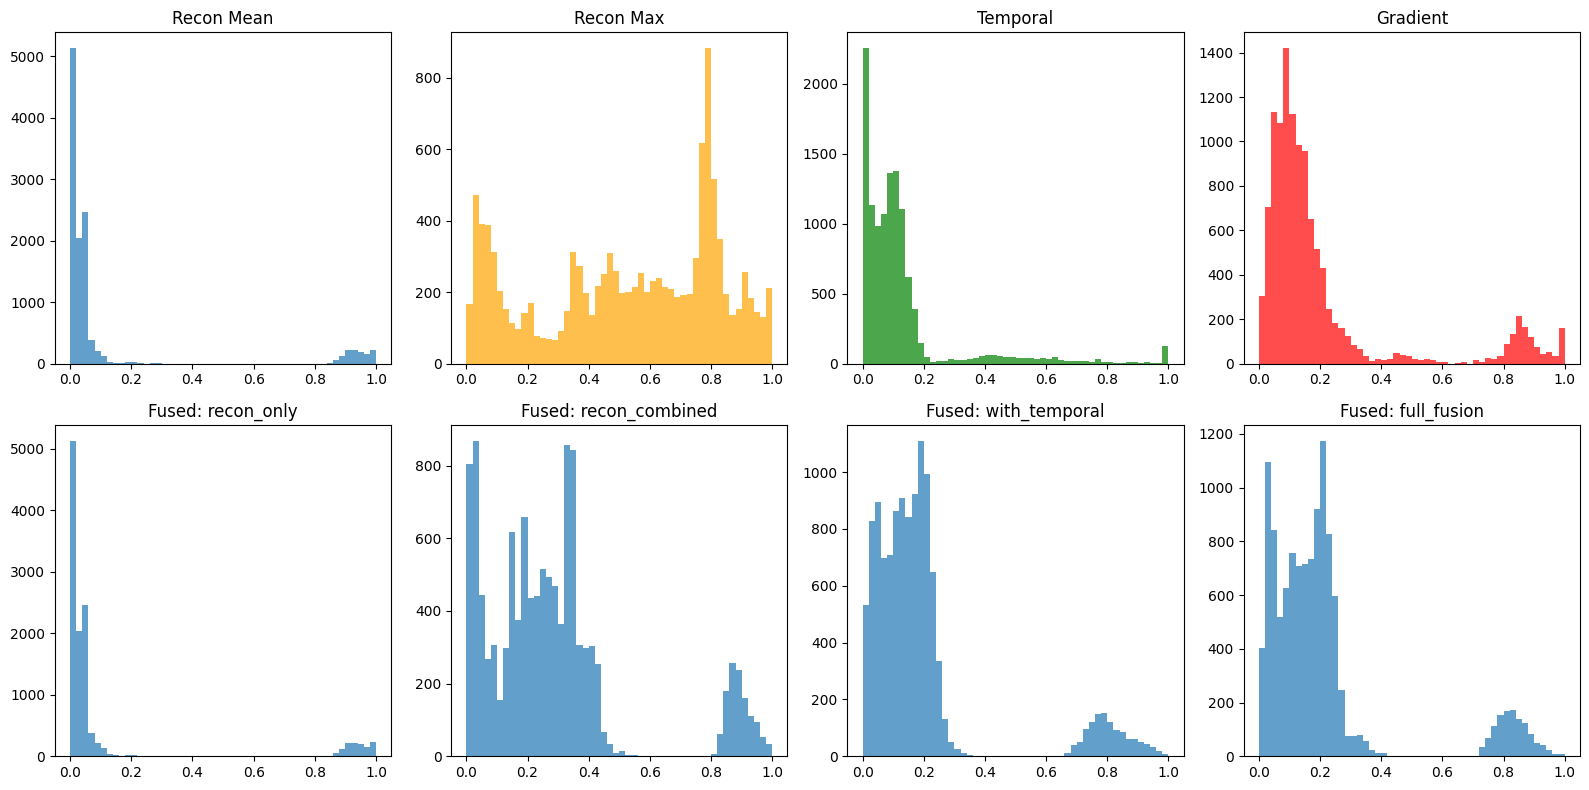

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Individual scores
axes[0, 0].hist(list(recon_mean_norm.values()), bins=50, alpha=0.7)
axes[0, 0].set_title('Recon Mean')

axes[0, 1].hist(list(recon_max_norm.values()), bins=50, alpha=0.7, color='orange')
axes[0, 1].set_title('Recon Max')

axes[0, 2].hist(list(temporal_norm.values()), bins=50, alpha=0.7, color='green')
axes[0, 2].set_title('Temporal')

axes[0, 3].hist(list(gradient_norm.values()), bins=50, alpha=0.7, color='red')
axes[0, 3].set_title('Gradient')

# Fused scores
for idx, name in enumerate(['recon_only', 'recon_combined', 'with_temporal', 'full_fusion']):
    if idx < 4:
        axes[1, idx].hist(list(fused_scores[name].values()), bins=50, alpha=0.7)
        axes[1, idx].set_title(f'Fused: {name}')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'distributions.png'))
plt.show()

In [21]:
def save_submission(scores, filename):
    data = [{'Id': fid, 'Predicted': scores.get(fid, 0)} for fid in test_frame_ids]
    df = pd.DataFrame(data)
    path = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(path, index=False)
    print(f"Saved: {filename} ({len(df)} rows)")
    return df

submissions = {}
for name, scores in fused_scores.items():
    submissions[name] = save_submission(scores, f'sub_{name}.csv')

print(f"\nGenerated {len(submissions)} submissions")

Saved: sub_recon_only.csv (11706 rows)
Saved: sub_recon_combined.csv (11706 rows)
Saved: sub_with_temporal.csv (11706 rows)
Saved: sub_with_gradient.csv (11706 rows)
Saved: sub_full_fusion.csv (11706 rows)
Saved: sub_temporal_heavy.csv (11706 rows)
Saved: sub_max_heavy.csv (11706 rows)

Generated 7 submissions


In [22]:
print("Preview of 'recon_combined' submission:")
print(submissions['recon_combined'].head(10))
print(f"\nScore range: [{submissions['recon_combined']['Predicted'].min():.4f}, "
      f"{submissions['recon_combined']['Predicted'].max():.4f}]")

Preview of 'recon_combined' submission:
      Id  Predicted
0  1_939   0.445380
1  1_940   0.471242
2  1_941   0.474118
3  1_942   0.462085
4  1_943   0.456873
5  1_944   0.855296
6  1_945   0.377334
7  1_946   0.352367
8  1_947   0.365905
9  1_948   0.410332

Score range: [0.0000, 1.0000]


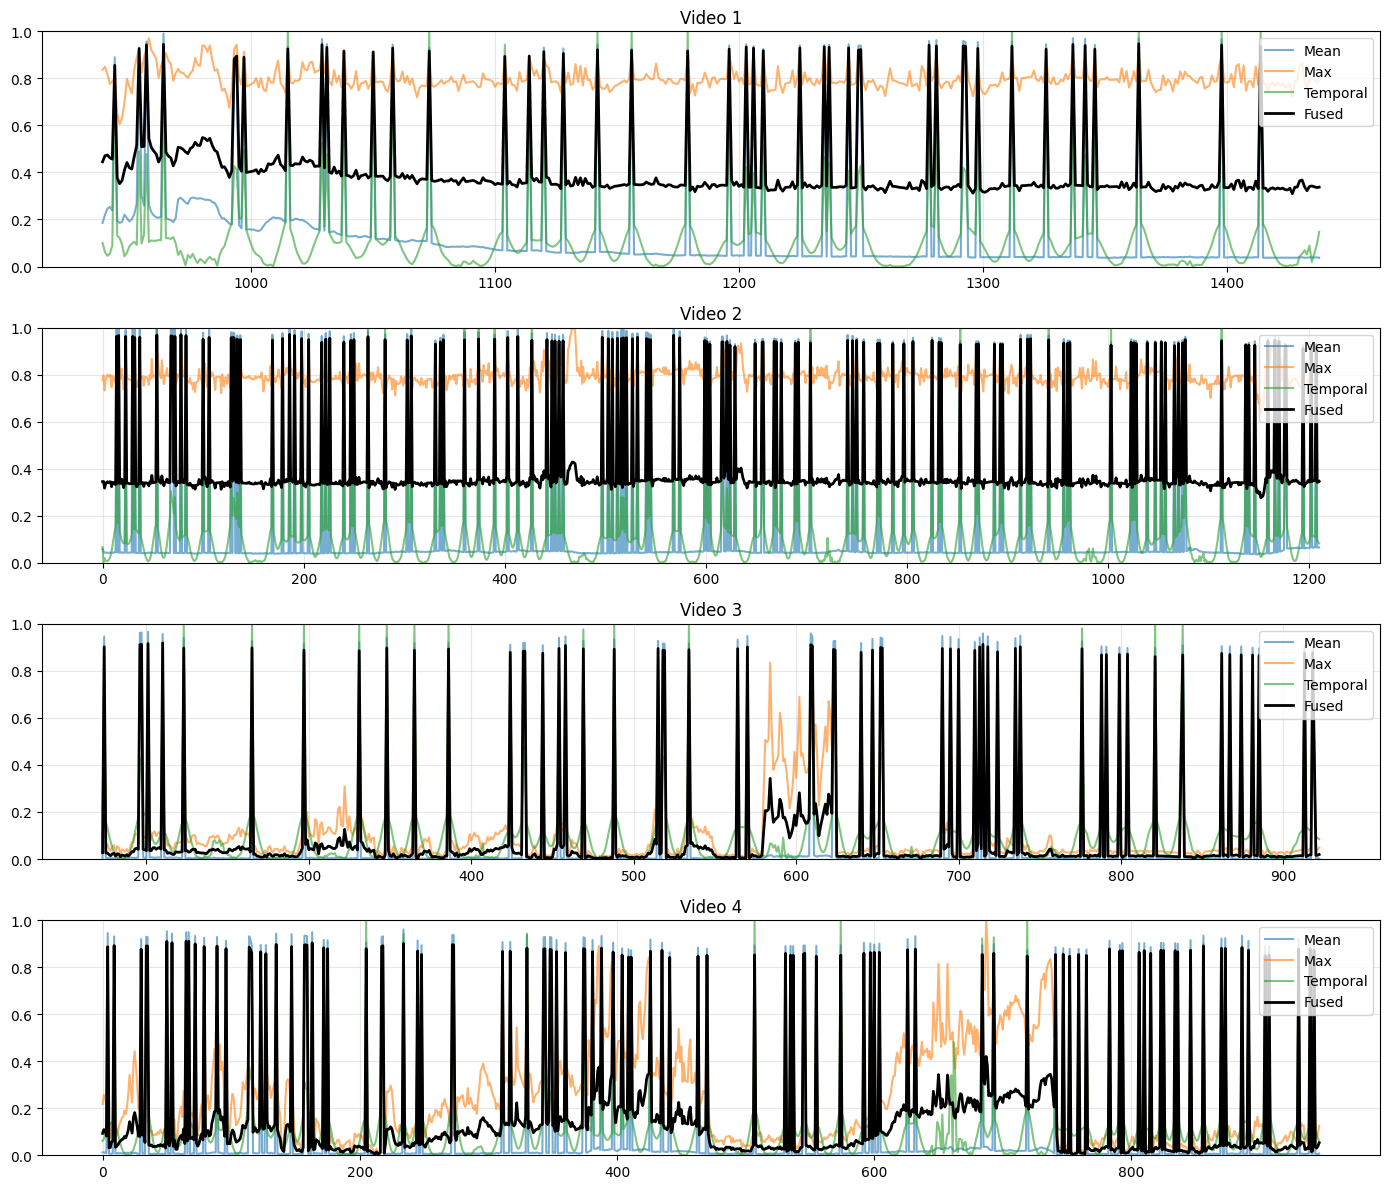

In [23]:
n_vids = min(4, len(test_frames))
fig, axes = plt.subplots(n_vids, 1, figsize=(14, 3*n_vids))
if n_vids == 1:
    axes = [axes]

for idx, vid in enumerate(sorted(test_frames.keys())[:n_vids]):
    fnums = sorted([f[0] for f in test_frames[vid]])
    
    rm = [recon_mean_norm.get(f"{vid}_{f}", 0) for f in fnums]
    rx = [recon_max_norm.get(f"{vid}_{f}", 0) for f in fnums]
    t = [temporal_norm.get(f"{vid}_{f}", 0) for f in fnums]
    fused = [fused_scores['recon_combined'].get(f"{vid}_{f}", 0) for f in fnums]
    
    axes[idx].plot(fnums, rm, label='Mean', alpha=0.6)
    axes[idx].plot(fnums, rx, label='Max', alpha=0.6)
    axes[idx].plot(fnums, t, label='Temporal', alpha=0.6)
    axes[idx].plot(fnums, fused, label='Fused', color='black', linewidth=2)
    
    axes[idx].set_title(f'Video {vid}')
    axes[idx].set_ylim(0, 1)
    axes[idx].legend(loc='upper right')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal.png'))
plt.show()

In [24]:
print("Score Statistics:")
print("-" * 50)
for name in ['recon_mean_norm', 'recon_max_norm', 'temporal_norm', 'gradient_norm']:
    scores = eval(name)
    vals = list(scores.values())
    print(f"{name:20s}: mean={np.mean(vals):.4f}, std={np.std(vals):.4f}, "
          f"median={np.median(vals):.4f}")

Score Statistics:
--------------------------------------------------
recon_mean_norm     : mean=0.1215, std=0.2776, median=0.0263
recon_max_norm      : mean=0.5278, std=0.2937, median=0.5724
temporal_norm       : mean=0.1272, std=0.1748, median=0.0869
gradient_norm       : mean=0.2063, std=0.2438, median=0.1217


In [25]:
del train_tensors, test_tensors
gc.collect()
torch.cuda.empty_cache()
print("Cleanup done!")

Cleanup done!
